<a href="https://colab.research.google.com/github/Seongjin1225/AI_School_9th_Final_Project_TEAM_3/blob/main/Unet_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net 코드

In [ ]:
# 필요 라이브러리 호출
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

# Importing the required library and modules
import os
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
#plt.style.use("ggplot")
# %matplotlib inline

import cv2
from PIL import Image,ImageDraw,ImageFont
import sklearn as sk
from tqdm import tqdm
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from skimage.morphology import label
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 데이터 갯수 동일화 작업

In [ ]:
# kidney_3_dense에는 이미지 폴더가 없고 labels만 존재
# images는 sparse에 있으므로 sparse에서 가져와야한다!!(500개)

directory_path_train = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/train'

# 파일 경로를 리스트 형태로 저장하는 함수
def list_files_in_directory(directory_path = directory_path_train):
    direc = []
    for root, dirs, files in os.walk(directory_path):
        for dire in dirs:
            if dire in ["labels","images"]:
                continue
            file_path = os.path.join(root, dire)
            direc.append(file_path)
            # print(file_path)
    return direc


# train data를 위한 전처리 이므로
# train_folders라는 변수에 train 데이터 파일 경로 저장
train_folders = list_files_in_directory(directory_path_train)
train_folders

# 폴더 내부 총 이미지 파일의 개수 count하는 함수
def count_total_img(folders = train_folders):
    sub_f = ["images","labels"]  # 분류를 위한 하위 카테고리
    path = []  # 하위 디렉토리 경로 저장할 리스트
    total_files = []  # 해당 하위 디렉토리의 전체 파일 수 저장할 리스트
    for dire in folders:  # folders 내부의 파일 경로들에 대해
        for subf in sub_f:  # subf = images, labels
            if (dire =="/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/train/kidney_3_dense") & (subf != "labels"):
                continue  # 경로가 kidney_3_dense이고 하위 카테고리가 labels 가 아닌 경우, 즉 images인 경우 contin

            _dir = dire + "/" + subf  # 하위 디렉토리 경로 생성
            total_sample = len(os.listdir(_dir))  # 해당 디렉토리의 파일 수 계산
            # print(f"{_dir}: {total_sample}")
            path.append(_dir)  # path 리스트에 하위 디렉토리 경로 저장
            total_files.append(total_sample)  # 하위 디렉토리의 전체 파일 수 저장
    obj = {
        "path": path,
        "total_files":total_files
    }
    return obj  # 디렉토리 경로와 파일 수를 obj라는 딕셔너리에 저장

train_file_dir = count_total_img()  # count_total_img 함수 호출

folders = train_file_dir
_paths = list(zip(folders['path'], folders['total_files']))
# 위에서 함수로 불러온 딕셔너리에서 각각의 키값에 해당하는 값들을 불러와 zip을 사용해 묶어 리스트로 변환

train_images = []  # images 디렉토리 저장할 리스트 생성
train_labels = []  # labels 디렉토리 저장할 리스트 생성

for path, total_files in _paths:
    split_text = path.split("/")  # '/'을 기준으로 분리

    if 'labels' in split_text:  # labels가 포함된 경우
        label_path = os.path.join(*split_text)  # os.path.join을 사용해 경로로 생성
        train_labels.extend(glob(f'/{label_path}/*.tif'))  # 해당 경로 내부의 .tif 파일을 리스트에 추가

    if 'images' in split_text:  # images가 포함된 경우
        image_path = os.path.join(*split_text) # os.path.join을 사용해 경로로 생성
        train_images.extend(glob(f'/{image_path}/*.tif')) # 해당 경로 내부의 .tif 파일을 리스트에 추가

    if 'kidney_3_dense' in split_text:  # kindey_3_dense가 포함된 경우
        image_path = os.path.join(*split_text).replace('kidney_3_dense', 'kidney_3_sparse').replace('labels','images')
        train_images.extend(glob(f'/{image_path}/*.tif')[:501])

        # kideney_3_dense를 kidney_3_sparse로 대체하고 lables를 images로 대체하고 앞에서부터 500개 슬라이싱
        # kidney_3_dense에 images data가 없는데 이를 해소하기 위한 작업

print(len(train_images))  # 7429
print(len(train_labels))  # 7429
# 각각의 리스트의 길이를 출력해보면 같아진 것을 알 수 있다.

7429
7429


# 데이터 전처리 및 U-Net 구현 및 학습

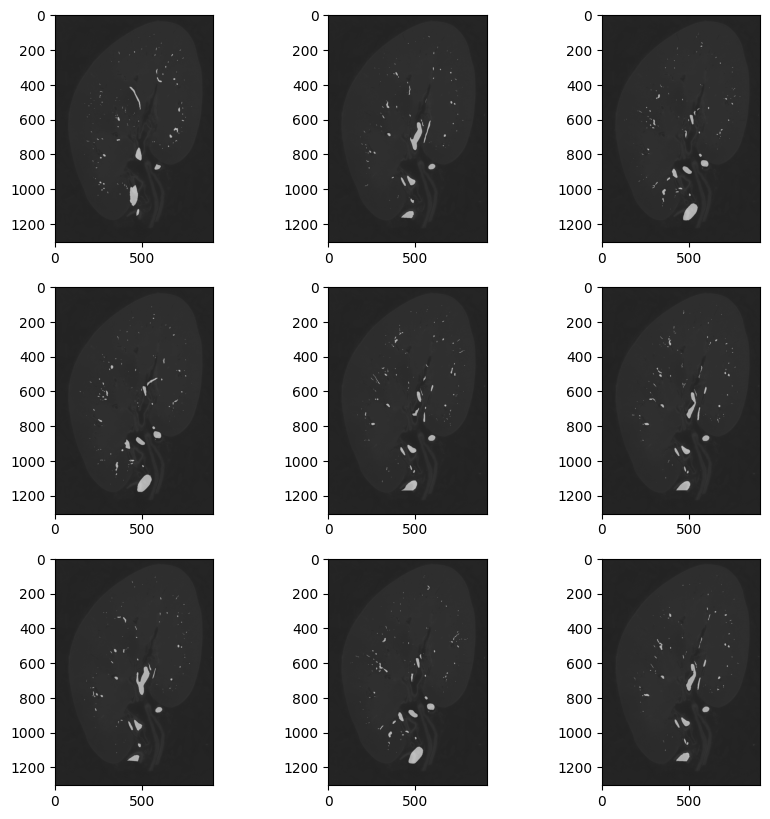

                                            filename  \
0  /content/drive/MyDrive/Final_Project/blood-ves...   
1  /content/drive/MyDrive/Final_Project/blood-ves...   
2  /content/drive/MyDrive/Final_Project/blood-ves...   
3  /content/drive/MyDrive/Final_Project/blood-ves...   
4  /content/drive/MyDrive/Final_Project/blood-ves...   

                                                mask  
0  /content/drive/MyDrive/Final_Project/blood-ves...  
1  /content/drive/MyDrive/Final_Project/blood-ves...  
2  /content/drive/MyDrive/Final_Project/blood-ves...  
3  /content/drive/MyDrive/Final_Project/blood-ves...  
4  /content/drive/MyDrive/Final_Project/blood-ves...  
(4754, 2)
(1189, 2)
(1486, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                    

In [ ]:
#Sanity checking
# 이미지 시각화해서 확인하는 부분
rows,cols=3,3  # 행과 열 개수 지정
fig=plt.figure(figsize=(10,10))  # 도화지 만들어서 사이즈 지정
for i in range(1,rows*cols+1):  # 반복문 9번 실행
    fig.add_subplot(rows,cols,i)  # 현재 순서의 subplot 생성

    img_path=train_images[i]  # 현재 순서의 image 파일 가져옴
    msk_path=train_labels[i]  # 현재 순서의 labels 파일 가져옴

    img=cv2.imread(img_path)  # 가져온 image 파일 읽기
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    msk=cv2.imread(msk_path)  # 가져온 labels 파일 읽기
    plt.imshow(img)  # 이미지 시각화
    plt.imshow(msk,alpha=0.55)  # labels 파일 시각화, 투명도 0.55로 설정
plt.show()

# 데이터 프레임으로 생성
df = pd.DataFrame(data={"filename": train_images, 'mask' : train_labels})
print(df.head())
df_train, df_test = train_test_split(df,test_size = 0.2, random_state=42)  # 전체를 train, test로 분리
df_train, df_val = train_test_split(df_train,test_size = 0.2, random_state=42)  # train을 다시 train과 valid로 구분

print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

# Data Augmentation
def train_generator(data_frame, batch_size, aug_dict,  # aug_dict => 이미지와 라벨에 적용할 데이터 증강 옵션을 담은 딕셔너리.
                    image_color_mode="grayscale",  # image 컬러는 흑백으로
                    mask_color_mode="grayscale",  # labels 컬러 역시 흑백으로
                    image_save_prefix="image",
                    mask_save_prefix="mask",
                    save_to_dir=None,  # 증강된 이미지 및 라벨을 저장할 디렉토리 경로
                    target_size=(256,256),  # 사이즈 지정
                    seed=1):  # random seed 값

    # ImageDataGenerator 생성
    image_datagen = ImageDataGenerator(**aug_dict) # 딕셔너리의 키 값을 키워드 인수로 전달
    mask_datagen = ImageDataGenerator(**aug_dict)  # 딕셔너리의 키 값을 키워드 인수로 전달

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        interpolation = 'nearest',
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = 'grayscale',
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        interpolation = 'nearest',
        seed = seed)

    train_gen = zip(image_generator, mask_generator)  # zip 함수로 두 개의 generator 결합
                                                      # image와 label이 한쌍의 튜플로 됨

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)  # 이 부분을 내부로 이동
        yield (img, mask)

# 이미지 정규화(0~1사의 값으로 변경) 및 이진화
def adjust_data(img,mask):
    img = img / 255  # image 파일에 대한 정규화 진행
    mask = mask / 255  # labels 파일에 대한 정규화 진행
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

# Define segmentation metrics
smooth = 1e-5  # 분모가 0이 되는 것을 막아주는 값으로, 일반적으로 1e-5 사용
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Score 계산 함수 정의
def dice_score(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) + smooth
    return (2.0 * intersection + smooth) / union

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# Define Model(모델 정의)
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

model = unet()
model.summary()

# Hyperparameters
EPOCHS = 1
BATCH_SIZE = 16
learning_rate = 1e-5
im_width = 256
im_height = 256
decay_step = 30
decay_rate = learning_rate / EPOCHS

#early stopping callback
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
csv_logger = CSVLogger('/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/unet_no_process_{}.log'.format(datetime.now().strftime("%Y_%m_%d-%H_%M")))

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            brightness_range=(1, 1.2),  # 명암도 설정(1은 기본값, 최대 밝기를 1.2로 설정)
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),  # 빈 딕셔너리를 의미하며, 검증 데이터는 이미지 변형 사용 x 의미
                                target_size=(im_height, im_width))



model = unet()

initial_learning_rate = learning_rate
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_step, decay_rate=decay_rate, staircase=False
)

decay_rate = learning_rate / EPOCHS

# 아래 주석 부분은 tensorflow 1.x 버전이므로 굳이 사용하지 않는 것 추천!
# opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

# model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", dice_coef,iou,tf.keras.metrics.Recall(),
#                                                            tf.keras.metrics.Precision()])

cp_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/unet_kidney_segmentation'
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["binary_accuracy", dice_coef, iou, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

callbacks = [ModelCheckpoint(cp_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False), csv_logger]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) // BATCH_SIZE)

model.save('/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/model_1')
print('저장이 완료되었습니다!')



# 전이 학습

In [ ]:
def pred_results_ft(TLmodel, FTmodel, test_df, number_of_img, height, width):
    for i in range(number_of_img):
        index = np.random.randint(0,len(test_df.index))
        print("Testing image", i+1, ":", index)

        img = cv2.imread(test_df['filename'].iloc[index])
        img = cv2.resize(img, (height, width))
        img = img[np.newaxis, :, :, :]
        img = img / 255
        tl_pred = TLmodel.predict(img)
        ft_pred = FTmodel.predict(img)

        plt.figure(figsize=(8,8))
        plt.subplot(1,4,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')

        plt.subplot(1,4,2)
        plt.imshow(np.squeeze(cv2.resize(cv2.imread(test_df['mask'].iloc[index]), (height, width))))
        plt.title('Original Mask')

        plt.subplot(1,4,3)
        plt.imshow(np.squeeze(tl_pred) > .5)
        plt.title('Prediction (Model 1)')

        plt.subplot(1,4,4)
        plt.imshow(np.squeeze(ft_pred) > .5)
        plt.title('Prediction (Model 2)')

        plt.show()


# 그래프 시각화 코드
import pickle

def plot_histories(histories):

    # Input: histories obtained from training using fit_generator
    for h, history in enumerate(histories):
        keys = history.history.keys()
        fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
        fig.suptitle('No. ' + str(h+1) + ' Fold Training Results' , fontsize=30)

        for k, key in enumerate(list(keys)[:len(keys)//2]):
            training = history.history[key]
            validation = history.history['val_' + key]

            epoch_count = range(1, len(training) + 1)

            axs[k].plot(epoch_count, training, 'r--')
            axs[k].plot(epoch_count, validation, 'b-')
            axs[k].legend(['Training ' + key, 'Validation ' + key])

    with open(str(h+1) + '_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
from keras.applications.vgg16 import VGG16

def TL_unet_model(input_shape):
    input_shape = input_shape
    base_VGG = VGG16(include_top = False,  # FC(Fully-Connected) layer 포함 x
                    weights = 'imagenet',  # 가중치
                    input_shape = input_shape)

    # freezing all layers in VGG16 (layer 동결)
    for layer in base_VGG.layers:
        layer.trainable = False

    bridge = base_VGG.get_layer('block5_conv3').output # 32
#     print(bridge.shape)

    # Decoder(확장 경로)
    up1 = Conv2DTranspose(512,(2,2), strides=(2,2),padding='same')(bridge)
#     print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer('block4_conv3').output], axis=3)
    conv6 = Conv2D(512, (3,3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3,3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
#     print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
#     print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
#     print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#     print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model

In [ ]:
input_shape = (im_height, im_width, 3)
#output_shape = (256, 256, 1)
# K.clear_session()
unet_model = TL_unet_model(input_shape)

layers = [(layer, layer.name, layer.trainable) for layer in unet_model.layers]
unet_model_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

# display(unet_model_df)

batch_size = 16
epochs = 1


unet_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])

checkpoint_path = '/kaggle/working/unet_kidney_segmentation.h5'

pretrain_csvlogger = CSVLogger(filename='/kaggle/working/pretrain_training_log.csv', separator=",", append=True)

model_checkpoint = ModelCheckpoint(checkpoint_path,
                                    verbose=1,
                                    monitor='val_loss',
                                    save_best_only=True)

callbacks_list = [model_checkpoint, pretrain_csvlogger]

history = unet_model.fit(train_gen,
                                    steps_per_epoch=len(df_train)//batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    validation_data = test_gener,
                                    validation_steps = len(df_val)//batch_size,
                                    verbose=1)

In [ ]:
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

# 모델 호출
TLmodel = load_model(checkpoint_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

# 호출한 모델 컴파일
TLmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(df_test, BATCH_SIZE,
                               dict(),
                               target_size = (im_height, im_width))

results = TLmodel.evaluate(evaluate_gen,
                                    steps=len(df_test)//BATCH_SIZE,
                                    verbose=1)

results = dict(zip(TLmodel.metrics_names,results))

histories.append(history)
accuracies.append(results['binary_accuracy'])
losses.append(results['loss'])
dicecoefs.append(results['dice_coef'])
ious.append(results['iou'])

print('Evaluation scores from pretrained model:')
print('Accuracy: ', accuracies)
print('Loss: ', losses)
print('Dice coefficient: ', dicecoefs)
print('IOU: ', ious)

plot_histories(histories)

In [ ]:
# 동결 해제 시키는 fine tuning 함수
def finetune_unfreezeall(input_shape, base_model):
    input_shape = input_shape
    base_model = base_model

    # unfreeze the contracting path and freeze the expanding path
    for layer in base_model.layers:
        if layer.name in ['block1_conv1', 'block1_conv2', 'block1_pool',
                          'block2_conv1', 'block2_conv2', 'block2_pool',
                          'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool',
                          'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',
                          'block5_conv1', 'block5_conv2', 'block5_conv3']:
            layer.trainable = True

    return base_model

In [ ]:
TL_checkpoint_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/unet_kidney_segmentation'
TLmodel = load_model(TL_checkpoint_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
FTmodel = finetune_unfreezeall(input_shape, TLmodel)

FTmodel.summary() # should have no non-trainable parameters

In [ ]:
# K-Fold 교차검증 부분
kf_histories = []
kf_losses = []
kf_accuracies = []
kf_dicecoefs = []
kf_ious = []

# same batch size and epochs
epochs = 1
batch_size = 16

# added KFold in here:
kf = KFold(n_splits = 5, shuffle=False)

for k, (train_index, test_index) in enumerate(kf.split(df)):
    kf_train_df = df.iloc[train_index]
    kf_test_df = df.iloc[test_index]

    kf_train_gen = train_generator(kf_train_df, batch_size,
                                train_generator_args,
                                target_size = (im_height, im_width))

    kf_test_gen = train_generator(kf_test_df, batch_size,
                               dict(),
                               target_size = (im_height, im_width))

    TLmodel = load_model(TL_checkpoint_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

    kf_model = finetune_unfreezeall(input_shape, TLmodel)
    kf_model.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])

    kf_checkpoint_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/' + str(k+1) + '_KFold_ft_unet_kidney_segmentation_new.h5'

    kf_model_checkpoint = ModelCheckpoint(kf_checkpoint_path,
                                         verbose=1,
                                         monitor='val_loss',
                                         save_best_only=True)

    kf_csvlogger = CSVLogger(filename='Unet/model_v1_1/'+str(k+1)+'KF_training_log.csv', separator=",", append=True)

    kf_callbacks_list = [kf_model_checkpoint, kf_csvlogger]

    print('------------------------------------------------------------------------')
    print('Training for fold ', k+1)

    kf_history = kf_model.fit(kf_train_gen,
                                       steps_per_epoch=len(kf_train_df)//batch_size,
                                       epochs=epochs,
                                       callbacks=kf_callbacks_list,
                                       validation_data = kf_test_gen,
                                       validation_steps = len(kf_test_df)//batch_size,
                                       verbose=1)

    KFmodel = load_model(kf_checkpoint_path,
                       custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])


    # another generator for evaluate_generator
    kf_evaluate_gen = train_generator(kf_test_df, batch_size,
                                   dict(),
                                   target_size = (im_height, im_width))

    kf_results = KFmodel.evaluate(kf_evaluate_gen,
                                      steps=len(kf_test_df)//batch_size)
    kf_results = dict(zip(KFmodel.metrics_names,kf_results))

    kf_histories.append(kf_history)
    kf_accuracies.append(kf_results['binary_accuracy'])
    kf_losses.append(kf_results['loss'])
    kf_dicecoefs.append(kf_results['dice_coef'])
    kf_ious.append(kf_results['iou'])


kf_results_df = pd.DataFrame(data={'Accuracy': kf_accuracies, 'Loss': kf_losses, 'Dice coef': kf_dicecoefs, 'IOU': kf_ious},
                             dtype = np.float64)
kf_results_df.to_csv(path_or_buf='Unet/model_v1_1/kf5_results.csv')
display(kf_results_df)

# plot_histories(kf_histories)

# Print all the evaluation scores:
print('Evaluation scores from 5 Fold fine-tuning model:')
print('Accuracies : ', kf_accuracies)
print('Losses : ', kf_losses)
print('Dice coefficients : ', kf_dicecoefs)
print('IOUs : ', kf_ious)

print('')

# 평균
print('Average accuracy : ', np.mean(np.array(kf_accuracies)))
print('Average loss : ', np.mean(np.array(kf_losses)))
print('Average dice coefficient : ', np.mean(np.array(kf_dicecoefs)))
print('Average IOU : ', np.mean(np.array(kf_ious)))

print('')

# 표준편차
print('SD of accuracy : ', np.std(np.array(kf_accuracies)))
print('SD of loss : ', np.std(np.array(kf_losses)))
print('SD of dice coefficient : ', np.std(np.array(kf_dicecoefs)))
print('SD of iou : ', np.std(np.array(kf_ious)))

In [ ]:
TLmodel_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/unet_kidney_segmentation'
TLmodel = load_model(TLmodel_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
TLmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(df_test, batch_size,
                               dict(),
                               (im_height, im_width))

val_loss, val_iou, val_dice, val_accuracy = TLmodel.evaluate(evaluate_gen,
                                                steps=len(df_test)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet TL model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)


In [ ]:
KFmodel_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/1_KFold_ft_unet_kidney_segmentation_new.h5'
KFmodel = load_model(KFmodel_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(df_test, batch_size,
                               dict(),
                               (im_height, im_width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate(evaluate_gen,
                                                steps=len(df_test)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)

Fmodel_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/2_KFold_ft_unet_kidney_segmentation_new.h5'
KFmodel = load_model(KFmodel_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(df_test, batch_size,
                               dict(),
                               (im_height, im_width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate(evaluate_gen,
                                                steps=len(df_test)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)


KFmodel_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/3_KFold_ft_unet_kidney_segmentation_new.h5'
KFmodel = load_model(KFmodel_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(df_test, batch_size,
                               dict(),
                               (im_height, im_width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate(evaluate_gen,
                                                steps=len(df_test)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)


KFmodel_path = '/content/drive/MyDrive/Final_Project/blood-vessel-segmentation/4_KFold_ft_unet_kidney_segmentation_new.h5'
KFmodel = load_model(KFmodel_path,
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(df_test, batch_size,
                               dict(),
                               (im_height, im_width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate(evaluate_gen,
                                                steps=len(df_test)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)

In [ ]:
pred_results_ft(TLmodel, KFmodel, df_test, 5, im_height, im_width)

# 결과 확인

In [ ]:
# a = history.history

# list_traindice = a['dice_coef']
# list_testdice = a['val_dice_coef']

# list_trainjaccard = a['iou']
# list_testjaccard = a['val_iou']

# list_trainloss = a['loss']
# list_testloss = a['val_loss']

# plt.figure(1)
# plt.plot(list_testloss, 'b-')
# plt.plot(list_trainloss,'r-')
# plt.xlabel('Epochs')
# plt.ylabel('Dice Loss')
# plt.title('Loss Graph', fontsize = 15)

# plt.figure(2)
# plt.plot(list_traindice, 'r-')
# plt.plot(list_testdice, 'b-')
# plt.xlabel('Epochs')
# plt.ylabel('Dice Coefficient')
# plt.title('Dice Coefficient Graph', fontsize = 15)
# plt.show()

# plt.figure(3)
# plt.plot(list_trainjaccard, 'b-')
# plt.plot(list_testjaccard, 'r-')
# plt.xlabel('Epochs')
# plt.ylabe('IOU')
# plt.title('IOU Graph',fontsize=15)
# plt.show()

# 예측 및 시각화

In [ ]:
# # convert the history.history dict to a pandas DataFrame and save as csv for
# # future plotting
# import pandas as pd
# unet_history_df = pd.DataFrame(history.history)
# with open('unet_history_df.csv', mode='w') as f:
#     unet_history_df.to_csv(f)


# model = load_model('unet_process', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_score': dice_score, 'dice_coef': dice_coef, 'iou':iou})

# # Testing the results
# test_gen = train_generator(df_test, BATCH_SIZE,
#                                 dict(),
#                                 target_size=(im_height, im_width))

# results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

# print("Test lost: ",results[0])
# print("Test Dice Score: ",results[1])
# print("Test Dice Coefficent: ",results[2])
# print("Test IOU: ",results[3])

# for i in range(1):
#     index = np.random.randint(1, len(df_test.index))
#     img_path = df_test['filename'].iloc[index]
#     img1 = cv2.imread(img_path)
#     # img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img1, (im_height, im_width))
#     img = img / 255
#     img = img[:, :, 0]
#     img = img[np.newaxis, :, :]
#     pred = model.predict(img)

#     plt.figure(figsize=(12, 12))
#     plt.subplot(1, 4, 1)
#     plt.imshow(np.squeeze(img1))
#     plt.title('Original Image')

#     plt.subplot(1, 4, 2)
#     mask_path = df_test['mask'].iloc[index]
#     mask = cv2.imread(mask_path)
#     plt.imshow(mask)
#     plt.title('Original Mask')

#     plt.subplot(1, 4, 3)
#     pre = np.squeeze(pred)
#     plt.imshow(pre, cmap='gray')
#     plt.title('Prediction Mask')

# RLE Encoding 및 submission.csv 생성 부분은 추가 예정

In [ ]:
# import tifffile as tiff
# import tensorflow as tf
# def preprocess_image(path):
#     # Load the image using tifffile
#     image = tiff.imread(path)

#     # If the image has more than one channel, extract just one channel
#     if image.ndim > 2 and image.shape[2] > 1:
#         image = image[..., 0]

#     # Normalize the image to [0, 1] range
#     image = image / 255.0

#     # Convert image to a TensorFlow tensor
#     image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

#     # Add a channel dimension if it does not exist
#     if image_tensor.ndim == 2:
#         image_tensor = image_tensor[..., tf.newaxis]

#     # Ensure image tensor is 3D at this point
#     if image_tensor.ndim != 3:
#         raise ValueError('Image tensor must be 3 dimensions [height, width, channels]')

#     # Resize the image to the desired size
#     image_tensor = tf.image.resize(image_tensor, [256, 256])

#     return image_tensor

In [ ]:
# def rle_encode(img):
#     '''
#     img: numpy array, 1 - mask, 0 - background
#     Returns run length as string formated
#     '''
#     img =  cv2.resize(img , (1303, 912) ,  interpolation = cv2.INTER_NEAREST )
#     pixels = img.flatten()
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     rle = ' '.join(str(x) for x in runs)
#     if rle=='':
#         rle = '1 0'
#     return rle

In [ ]:
# from glob import glob
# import os

# test_base_path = '/kaggle/input/blood-vessel-segmentation/test'
# test_image_files = []

# for dataset in os.listdir(test_base_path):
#     images_path = os.path.join(test_base_path, dataset, 'images')
#     if os.path.isdir(images_path):
#         test_image_files += sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])

# test_images = np.array([preprocess_image(f) for f in test_image_files])



# # Print shapes for debugging
# print("test_images shape:", test_images.shape)

# prediction = model.predict(test_images)

# # Print prediction shape for debugging
# print("prediction shape:", prediction.shape)

# thresholded_masks = (prediction > 0.1).astype(np.uint8)

# rles = [rle_encode(mask.reshape(256, 256)) for mask in thresholded_masks]
# ids = [f'{p.split("/")[-3]}_{os.path.basename(p).split(".")[0]}' for p in test_image_files]

# # Create a DataFrame for debugging
# submission = pd.DataFrame({
#     "id": ids,
#     "rle": rles
# })

# # Print the first few rows of the DataFrame
# print(submission.head(10))